# Conditional DDPM for Strabismus Detection
## Binary Classification: Strabismus vs Normal

This notebook implements a Conditional Denoising Diffusion Probabilistic Model (DDPM) for generating eye images conditioned on class labels (Strabismus or Normal).

**Dataset Structure:**
- Normal: 105 images
- Strabismus: 209 images (4 subtypes combined)

**Hardware:**
- GPU: RTX A6000
- CUDA: 12.4
- Python: 3.11.14

## 1. Setup and Imports

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm
import json
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image

# Wandb for experiment tracking
import wandb

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"Available GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cuda
GPU: NVIDIA RTX A6000
CUDA Version: 12.1
Available GPU Memory: 51.53 GB


## 2. Configuration

In [11]:
# Dataset Configuration
DATA_DIR = Path('STRABISMUS_PREPROCESSED')  # Updated to use preprocessed dataset
IMG_SIZE = 128  # Reduced to 128x128 for faster training
BATCH_SIZE = 16  # Increased batch size for 128x128 images
NUM_WORKERS = 0  # Set to 0 to fix Windows DataLoader issues

# Model Configuration
NUM_CLASSES = 2  # 0: Strabismus, 1: Normal
CHANNELS = 3  # RGB images
TIME_EMB_DIM = 256
CLASS_EMB_DIM = 128

# DDPM Configuration
TIMESTEPS = 1000
BETA_START = 0.0001
BETA_END = 0.02

# Training Configuration
EPOCHS = 500
LEARNING_RATE = 2e-4
SAVE_EVERY = 50
SAMPLE_EVERY = 25
NUM_SAMPLES = 8  # Number of samples to generate during training

# Wandb Configuration
WANDB_PROJECT = "conditional-ddpm-strabismus"
WANDB_ENTITY = None  # Set to your wandb username if needed
USE_WANDB = True  # Set to False to disable wandb

# Output directories
OUTPUT_DIR = Path('outputs')
CHECKPOINT_DIR = OUTPUT_DIR / 'checkpoints'
SAMPLE_DIR = OUTPUT_DIR / 'samples'

# Create directories
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)
SAMPLE_DIR.mkdir(parents=True, exist_ok=True)

print(f"Configuration set up successfully!")
print(f"Dataset directory: {DATA_DIR}")
print(f"Image size: {IMG_SIZE}x{IMG_SIZE}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Timesteps: {TIMESTEPS}")
print(f"NUM_WORKERS: {NUM_WORKERS} (0 = single-threaded, fixes Windows issues)")
print(f"Wandb tracking: {'Enabled' if USE_WANDB else 'Disabled'}")
print(f"\nNote: 128x128 will train ~4x faster than 256x256!")

Configuration set up successfully!
Dataset directory: STRABISMUS_PREPROCESSED
Image size: 128x128
Batch size: 16
Timesteps: 1000
NUM_WORKERS: 0 (0 = single-threaded, fixes Windows issues)
Wandb tracking: Enabled

Note: 128x128 will train ~4x faster than 256x256!


## 3. Dataset Preparation

In [12]:
class StrabismusDataset(Dataset):
    """
    Custom dataset for Strabismus vs Normal classification.
    Works with preprocessed dataset where all strabismus types are in one folder.
    Images are preprocessed to 256x256 and will be resized to target size.
    """
    def __init__(self, root_dir, img_size=128, transform=None):
        self.root_dir = Path(root_dir)
        self.img_size = img_size
        self.transform = transform
        
        # Load all image paths and labels
        self.data = []
        
        # Load strabismus images (class 0)
        strab_dir = self.root_dir / 'STRABISMUS'
        if strab_dir.exists():
            for img_path in strab_dir.glob('*.jpg'):
                self.data.append((img_path, 0))  # 0 = strabismus
        
        # Load normal images (class 1)
        normal_dir = self.root_dir / 'NORMAL'
        if normal_dir.exists():
            for img_path in normal_dir.glob('*.jpg'):
                self.data.append((img_path, 1))  # 1 = normal
        
        # Default transform if none provided
        if self.transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((img_size, img_size)),  # Resize from 256x256 to target
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.ToTensor(),
                transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1, 1]
            ])
        
        print(f"Dataset loaded from: {self.root_dir}")
        print(f"  Total images: {len(self.data)}")
        strab_count = sum(1 for _, label in self.data if label == 0)
        normal_count = sum(1 for _, label in self.data if label == 1)
        print(f"  Strabismus: {strab_count}")
        print(f"  Normal: {normal_count}")
        print(f"  Images will be resized to {img_size}x{img_size}")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        
        # Load image
        image = Image.open(img_path).convert('RGB')
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Create dataset and dataloader
dataset = StrabismusDataset(DATA_DIR, img_size=IMG_SIZE)
dataloader = DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"\nDataLoader created with {len(dataloader)} batches")
print(f"Note: NUM_WORKERS={NUM_WORKERS} prevents multiprocessing errors on Windows")

Dataset loaded from: STRABISMUS_PREPROCESSED
  Total images: 314
  Strabismus: 209
  Normal: 105
  Images will be resized to 128x128

DataLoader created with 20 batches
Note: NUM_WORKERS=0 prevents multiprocessing errors on Windows


## 4. Visualize Dataset Samples

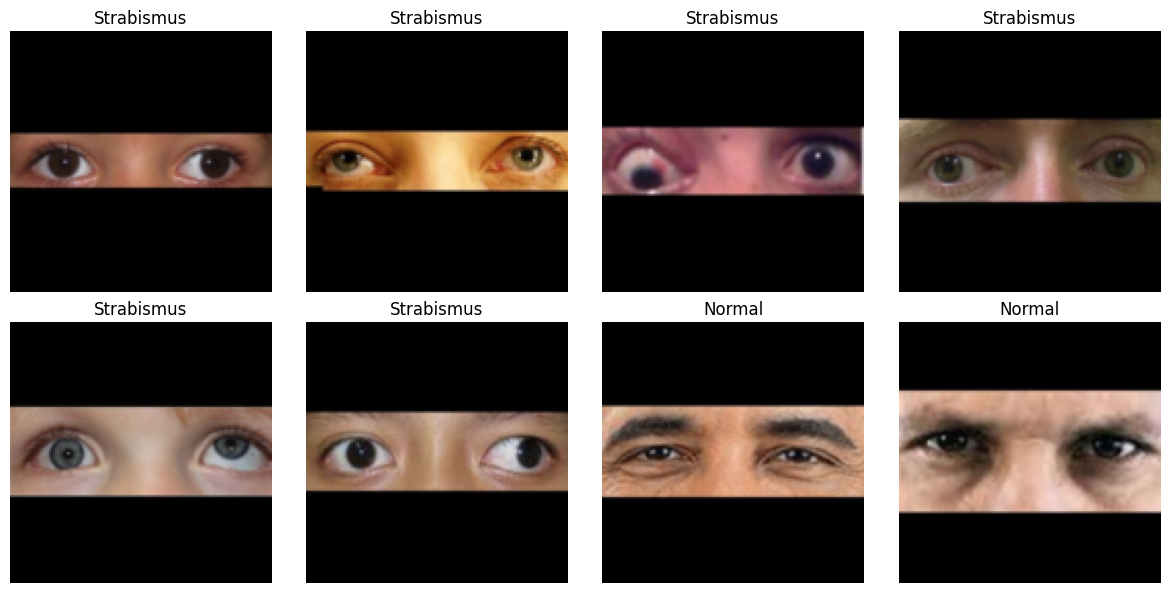

In [13]:
def show_images(images, labels, num_samples=8):
    """Visualize a batch of images with their labels"""
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()
    
    class_names = ['Strabismus', 'Normal']
    
    for i in range(min(num_samples, len(images))):
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = (img + 1) / 2  # Denormalize from [-1, 1] to [0, 1]
        img = np.clip(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(f"{class_names[labels[i]]}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Get a batch and visualize
sample_images, sample_labels = next(iter(dataloader))
show_images(sample_images, sample_labels)

## 5. DDPM Noise Scheduler

In [14]:
class DDPMScheduler:
    """
    Implements the noise schedule and sampling for DDPM.
    """
    def __init__(self, timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cuda'):
        self.timesteps = timesteps
        self.device = device
        
        # Linear beta schedule
        self.betas = torch.linspace(beta_start, beta_end, timesteps).to(device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.alphas_cumprod_prev = F.pad(self.alphas_cumprod[:-1], (1, 0), value=1.0)
        
        # Calculations for diffusion q(x_t | x_{t-1})
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)
        
        # Calculations for posterior q(x_{t-1} | x_t, x_0)
        self.posterior_variance = (
            self.betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        
        self.sqrt_recip_alphas = torch.sqrt(1.0 / self.alphas)
        self.posterior_mean_coef1 = (
            self.betas * torch.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        )
        self.posterior_mean_coef2 = (
            (1.0 - self.alphas_cumprod_prev) * torch.sqrt(self.alphas) / (1.0 - self.alphas_cumprod)
        )
    
    def add_noise(self, x_start, t, noise=None):
        """
        Add noise to the input image according to timestep t.
        q(x_t | x_0)
        """
        if noise is None:
            noise = torch.randn_like(x_start)
        
        sqrt_alphas_cumprod_t = self.sqrt_alphas_cumprod[t].reshape(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].reshape(-1, 1, 1, 1)
        
        return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise
    
    def sample_prev_timestep(self, x_t, t, predicted_noise):
        """
        Sample x_{t-1} given x_t and predicted noise.
        p(x_{t-1} | x_t)
        """
        # Get coefficients
        sqrt_recip_alphas_t = self.sqrt_recip_alphas[t].reshape(-1, 1, 1, 1)
        betas_t = self.betas[t].reshape(-1, 1, 1, 1)
        sqrt_one_minus_alphas_cumprod_t = self.sqrt_one_minus_alphas_cumprod[t].reshape(-1, 1, 1, 1)
        
        # Predict x_0
        model_mean = sqrt_recip_alphas_t * (
            x_t - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t
        )
        
        if t[0] == 0:
            return model_mean
        else:
            posterior_variance_t = self.posterior_variance[t].reshape(-1, 1, 1, 1)
            noise = torch.randn_like(x_t)
            return model_mean + torch.sqrt(posterior_variance_t) * noise

# Initialize scheduler
scheduler = DDPMScheduler(
    timesteps=TIMESTEPS,
    beta_start=BETA_START,
    beta_end=BETA_END,
    device=device
)

print(f"DDPM Scheduler initialized with {TIMESTEPS} timesteps")

DDPM Scheduler initialized with 1000 timesteps


## 6. U-Net Model with Class Conditioning

In [15]:
class SinusoidalPositionEmbeddings(nn.Module):
    """Sinusoidal position embeddings for timesteps"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class ResidualBlock(nn.Module):
    """Residual block with group normalization and time/class embedding"""
    def __init__(self, in_channels, out_channels, time_emb_dim, class_emb_dim):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.GroupNorm(8, in_channels),
            nn.SiLU(),
            nn.Conv2d(in_channels, out_channels, 3, padding=1)
        )
        
        # Time and class embedding projection
        self.time_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, out_channels)
        )
        
        self.class_emb = nn.Sequential(
            nn.SiLU(),
            nn.Linear(class_emb_dim, out_channels)
        )
        
        self.conv2 = nn.Sequential(
            nn.GroupNorm(8, out_channels),
            nn.SiLU(),
            nn.Conv2d(out_channels, out_channels, 3, padding=1)
        )
        
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, 1)
        else:
            self.shortcut = nn.Identity()
    
    def forward(self, x, time_emb, class_emb):
        h = self.conv1(x)
        
        # Add time and class embeddings
        h = h + self.time_emb(time_emb)[:, :, None, None]
        h = h + self.class_emb(class_emb)[:, :, None, None]
        
        h = self.conv2(h)
        return h + self.shortcut(x)


class AttentionBlock(nn.Module):
    """Self-attention block"""
    def __init__(self, channels, num_heads=4):
        super().__init__()
        self.num_heads = num_heads
        self.norm = nn.GroupNorm(8, channels)
        self.qkv = nn.Conv2d(channels, channels * 3, 1)
        self.proj = nn.Conv2d(channels, channels, 1)
    
    def forward(self, x):
        b, c, h, w = x.shape
        
        # Normalize and compute Q, K, V
        qkv = self.qkv(self.norm(x))
        q, k, v = qkv.chunk(3, dim=1)
        
        # Reshape for multi-head attention
        q = q.view(b, self.num_heads, c // self.num_heads, h * w).transpose(-1, -2)
        k = k.view(b, self.num_heads, c // self.num_heads, h * w)
        v = v.view(b, self.num_heads, c // self.num_heads, h * w).transpose(-1, -2)
        
        # Attention
        attn = torch.softmax(q @ k / np.sqrt(c // self.num_heads), dim=-1)
        out = (attn @ v).transpose(-1, -2).reshape(b, c, h, w)
        
        return x + self.proj(out)


class ConditionalUNet(nn.Module):
    """
    U-Net with time and class conditioning for DDPM.
    Optimized for 128x128 images with efficient attention.
    """
    def __init__(
        self,
        in_channels=3,
        out_channels=3,
        num_classes=2,
        base_channels=64,
        channel_mults=(1, 2, 4, 8),
        time_emb_dim=256,
        class_emb_dim=128,
        num_res_blocks=2,
        use_attention=(False, True, True, True)  # Attention at 64x64, 32x32, 16x16
    ):
        super().__init__()
        
        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.SiLU(),
            nn.Linear(time_emb_dim, time_emb_dim)
        )
        
        # Class embedding
        self.class_emb = nn.Embedding(num_classes, class_emb_dim)
        
        # Initial convolution
        self.conv_in = nn.Conv2d(in_channels, base_channels, 3, padding=1)
        
        # Build encoder
        self.encoder = nn.ModuleList()
        channels = [base_channels]
        now_channels = base_channels
        
        for i, mult in enumerate(channel_mults):
            out_channels_layer = base_channels * mult
            
            for _ in range(num_res_blocks):
                layers = [ResidualBlock(now_channels, out_channels_layer, time_emb_dim, class_emb_dim)]
                now_channels = out_channels_layer
                
                if use_attention[i]:
                    layers.append(AttentionBlock(now_channels))
                
                self.encoder.append(nn.ModuleList(layers))
                channels.append(now_channels)
            
            if i != len(channel_mults) - 1:
                # Downsample
                self.encoder.append(nn.ModuleList([nn.Conv2d(now_channels, now_channels, 3, stride=2, padding=1)]))
                channels.append(now_channels)
        
        # Middle
        self.middle = nn.ModuleList([
            ResidualBlock(now_channels, now_channels, time_emb_dim, class_emb_dim),
            AttentionBlock(now_channels),
            ResidualBlock(now_channels, now_channels, time_emb_dim, class_emb_dim)
        ])
        
        # Build decoder
        self.decoder = nn.ModuleList()
        
        for i, mult in reversed(list(enumerate(channel_mults))):
            out_channels_layer = base_channels * mult
            
            for j in range(num_res_blocks + 1):
                layers = [
                    ResidualBlock(
                        now_channels + channels.pop(),
                        out_channels_layer,
                        time_emb_dim,
                        class_emb_dim
                    )
                ]
                now_channels = out_channels_layer
                
                if use_attention[i]:
                    layers.append(AttentionBlock(now_channels))
                
                self.decoder.append(nn.ModuleList(layers))
            
            if i != 0:
                # Upsample
                self.decoder.append(nn.ModuleList([
                    nn.ConvTranspose2d(now_channels, now_channels, 4, stride=2, padding=1)
                ]))
        
        # Output
        self.conv_out = nn.Sequential(
            nn.GroupNorm(8, now_channels),
            nn.SiLU(),
            nn.Conv2d(now_channels, out_channels, 3, padding=1)
        )
    
    def forward(self, x, t, y):
        """
        Args:
            x: Input image [B, C, H, W]
            t: Timestep [B]
            y: Class label [B]
        """
        # Embed time and class
        time_emb = self.time_mlp(t)
        class_emb = self.class_emb(y)
        
        # Initial conv
        h = self.conv_in(x)
        
        # Encoder
        skips = [h]
        for module_list in self.encoder:
            for layer in module_list:
                if isinstance(layer, ResidualBlock):
                    h = layer(h, time_emb, class_emb)
                else:
                    h = layer(h)
            skips.append(h)
        
        # Middle
        for layer in self.middle:
            if isinstance(layer, ResidualBlock):
                h = layer(h, time_emb, class_emb)
            else:
                h = layer(h)
        
        # Decoder
        for module_list in self.decoder:
            for layer in module_list:
                if isinstance(layer, ResidualBlock):
                    h = torch.cat([h, skips.pop()], dim=1)
                    h = layer(h, time_emb, class_emb)
                else:
                    h = layer(h)
        
        # Output
        return self.conv_out(h)


# Initialize model - optimized for 128x128 images
print("Initializing model for 128x128 images...")
model = ConditionalUNet(
    in_channels=CHANNELS,
    out_channels=CHANNELS,
    num_classes=NUM_CLASSES,
    base_channels=64,
    channel_mults=(1, 2, 4, 8),  # 128->64->32->16
    time_emb_dim=TIME_EMB_DIM,
    class_emb_dim=CLASS_EMB_DIM,
    num_res_blocks=2,
    use_attention=(False, True, True, True)  # Attention at 64x64, 32x32, 16x16
).to(device)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"\nModel initialized successfully!")
print(f"  Parameters: {num_params:,}")
print(f"  Model size: {num_params * 4 / 1e6:.2f} MB (float32)")
print(f"  Architecture: U-Net for 128x128 images")
print(f"  Resolution flow: 128 -> 64 -> 32 -> 16 -> 32 -> 64 -> 128")
print(f"  Attention: At 64x64 (4K tokens), 32x32 (1K tokens), 16x16 (256 tokens)")
print(f"\nExpected speed: ~90 seconds/epoch (~12 hours for 500 epochs)")

Initializing model for 128x128 images...

Model initialized successfully!
  Parameters: 66,691,907
  Model size: 266.77 MB (float32)
  Architecture: U-Net for 128x128 images
  Resolution flow: 128 -> 64 -> 32 -> 16 -> 32 -> 64 -> 128
  Attention: At 64x64 (4K tokens), 32x32 (1K tokens), 16x16 (256 tokens)

Expected speed: ~90 seconds/epoch (~12 hours for 500 epochs)


## 7. Training Functions

In [16]:
def train_one_epoch(model, dataloader, optimizer, scheduler, device, epoch):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    
    pbar = tqdm(dataloader, desc=f"Epoch {epoch}")
    for batch_idx, (images, labels) in enumerate(pbar):
        images = images.to(device)
        labels = labels.to(device)
        
        # Sample random timesteps
        batch_size = images.shape[0]
        t = torch.randint(0, TIMESTEPS, (batch_size,), device=device).long()
        
        # Add noise
        noise = torch.randn_like(images)
        noisy_images = scheduler.add_noise(images, t, noise)
        
        # Predict noise
        predicted_noise = model(noisy_images, t, labels)
        
        # Calculate loss
        loss = F.mse_loss(predicted_noise, noise)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})
        
        # Log to wandb every 10 batches
        if USE_WANDB and batch_idx % 10 == 0:
            wandb.log({
                "batch_loss": loss.item(),
                "epoch": epoch,
                "batch": batch_idx + (epoch - 1) * len(dataloader)
            })
    
    return total_loss / len(dataloader)


@torch.no_grad()
def sample_images(model, scheduler, num_samples=8, classes=None, device='cuda'):
    """Generate images using the trained model"""
    model.eval()
    
    # If no classes specified, generate equal numbers of each class
    if classes is None:
        classes = torch.cat([
            torch.zeros(num_samples // 2, dtype=torch.long),  # Strabismus
            torch.ones(num_samples // 2, dtype=torch.long)    # Normal
        ]).to(device)
    else:
        classes = torch.tensor(classes, dtype=torch.long).to(device)
    
    # Start from random noise
    x = torch.randn(len(classes), CHANNELS, IMG_SIZE, IMG_SIZE).to(device)
    
    # Iteratively denoise
    for t in tqdm(reversed(range(TIMESTEPS)), desc="Sampling", total=TIMESTEPS):
        t_batch = torch.full((len(classes),), t, device=device, dtype=torch.long)
        predicted_noise = model(x, t_batch, classes)
        x = scheduler.sample_prev_timestep(x, t_batch, predicted_noise)
    
    return x, classes


def save_samples(images, classes, epoch, save_dir):
    """Save generated samples to disk and log to wandb"""
    # Denormalize images
    images = (images + 1) / 2
    images = torch.clamp(images, 0, 1)
    
    # Create grid
    grid = make_grid(images, nrow=4, padding=2)
    
    # Convert to numpy
    grid_np = grid.permute(1, 2, 0).cpu().numpy()
    
    # Save locally
    plt.figure(figsize=(12, 12))
    plt.imshow(grid_np)
    plt.axis('off')
    
    class_names = ['Strabismus', 'Normal']
    class_labels = [class_names[c.item()] for c in classes]
    plt.title(f"Epoch {epoch} - Classes: {', '.join(class_labels[:4])} (top row)")
    
    save_path = save_dir / f"epoch_{epoch:04d}.png"
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.close()
    
    # Log to wandb
    if USE_WANDB:
        # Log individual images with class labels
        wandb_images = []
        for i, (img, label) in enumerate(zip(images, classes)):
            wandb_images.append(
                wandb.Image(
                    img.permute(1, 2, 0).cpu().numpy(),
                    caption=f"{class_names[label.item()]}"
                )
            )
        
        wandb.log({
            f"generated_samples_epoch_{epoch}": wandb_images,
            "sample_grid": wandb.Image(grid_np, caption=f"Epoch {epoch}"),
            "epoch": epoch
        })


def save_checkpoint(model, optimizer, epoch, loss, save_path):
    """Save model checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, save_path)
    
    # Log checkpoint to wandb as artifact
    if USE_WANDB:
        artifact = wandb.Artifact(
            f"model_checkpoint_epoch_{epoch}",
            type="model",
            description=f"Model checkpoint at epoch {epoch} with loss {loss:.6f}"
        )
        artifact.add_file(str(save_path))
        wandb.log_artifact(artifact)


print("Training functions defined successfully with Wandb logging!")

Training functions defined successfully with Wandb logging!


## 8. Initialize Training

In [17]:
# Initialize Wandb
if USE_WANDB:
    wandb.init(
        project=WANDB_PROJECT,
        entity=WANDB_ENTITY,
        config={
            "img_size": IMG_SIZE,
            "batch_size": BATCH_SIZE,
            "epochs": EPOCHS,
            "learning_rate": LEARNING_RATE,
            "timesteps": TIMESTEPS,
            "beta_start": BETA_START,
            "beta_end": BETA_END,
            "num_classes": NUM_CLASSES,
            "base_channels": 64,
            "channel_mults": (1, 2, 4, 8),
            "time_emb_dim": TIME_EMB_DIM,
            "class_emb_dim": CLASS_EMB_DIM,
            "model_parameters": sum(p.numel() for p in model.parameters()),
            "optimizer": "AdamW",
            "lr_scheduler": "CosineAnnealingLR",
            "dataset_size": len(dataset),
            "device": str(device),
        },
        name=f"ddpm_{IMG_SIZE}x{IMG_SIZE}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    )
    
    # Watch model gradients and parameters
    wandb.watch(model, log="all", log_freq=100)
    
    print(f"Wandb initialized!")
    print(f"  Project: {WANDB_PROJECT}")
    print(f"  Run: {wandb.run.name}")
    print(f"  URL: {wandb.run.url}")
else:
    print("Wandb disabled - training will proceed without logging to wandb.ai")

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# Learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Training history
history = {
    'train_loss': [],
    'epochs': []
}

print("\nOptimizer and scheduler initialized!")
print(f"Starting learning rate: {LEARNING_RATE}")
print(f"\nReady to train for {EPOCHS} epochs!")

wandb: Currently logged in as: aymantauhid2 (aymantauhid2-sheridan-college) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Wandb initialized!
  Project: conditional-ddpm-strabismus
  Run: ddpm_128x128_20251104_014258
  URL: https://wandb.ai/aymantauhid2-sheridan-college/conditional-ddpm-strabismus/runs/maf9zo07

Optimizer and scheduler initialized!
Starting learning rate: 0.0002

Ready to train for 500 epochs!


## 9. Training Loop

In [18]:
# Training loop
print(f"Starting training at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Total epochs: {EPOCHS}")
print(f"Samples every {SAMPLE_EVERY} epochs")
print(f"Checkpoints every {SAVE_EVERY} epochs")
print("-" * 80)

for epoch in range(1, EPOCHS + 1):
    # Train
    avg_loss = train_one_epoch(model, dataloader, optimizer, scheduler, device, epoch)
    lr_scheduler.step()
    
    # Record history
    history['train_loss'].append(avg_loss)
    history['epochs'].append(epoch)
    
    # Get current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    
    # Log epoch metrics to wandb
    if USE_WANDB:
        wandb.log({
            "epoch": epoch,
            "train_loss": avg_loss,
            "learning_rate": current_lr,
        })
    
    print(f"Epoch {epoch}/{EPOCHS} - Loss: {avg_loss:.6f} - LR: {current_lr:.6f}")
    
    # Generate samples
    if epoch % SAMPLE_EVERY == 0 or epoch == 1:
        print(f"Generating samples...")
        samples, sample_classes = sample_images(model, scheduler, NUM_SAMPLES, device=device)
        save_samples(samples, sample_classes, epoch, SAMPLE_DIR)
        print(f"Samples saved to {SAMPLE_DIR}")
    
    # Save checkpoint
    if epoch % SAVE_EVERY == 0 or epoch == EPOCHS:
        checkpoint_path = CHECKPOINT_DIR / f"checkpoint_epoch_{epoch:04d}.pt"
        save_checkpoint(model, optimizer, epoch, avg_loss, checkpoint_path)
        print(f"Checkpoint saved to {checkpoint_path}")
    
    print("-" * 80)

print(f"\nTraining completed at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Finish wandb run
if USE_WANDB:
    wandb.finish()
    print("Wandb run finished!")

Starting training at 2025-11-04 01:43:03
Total epochs: 500
Samples every 25 epochs
Checkpoints every 50 epochs
--------------------------------------------------------------------------------


Epoch 1:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/500 - Loss: 0.406319 - LR: 0.000200
Generating samples...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to outputs\samples
--------------------------------------------------------------------------------


Epoch 2:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2/500 - Loss: 0.081409 - LR: 0.000200
--------------------------------------------------------------------------------


Epoch 3:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/500 - Loss: 0.060370 - LR: 0.000200
--------------------------------------------------------------------------------


Epoch 4:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4/500 - Loss: 0.054951 - LR: 0.000200
--------------------------------------------------------------------------------


Epoch 5:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/500 - Loss: 0.046799 - LR: 0.000200
--------------------------------------------------------------------------------


Epoch 6:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6/500 - Loss: 0.042254 - LR: 0.000200
--------------------------------------------------------------------------------


Epoch 7:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7/500 - Loss: 0.035490 - LR: 0.000200
--------------------------------------------------------------------------------


Epoch 8:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/500 - Loss: 0.037466 - LR: 0.000200
--------------------------------------------------------------------------------


Epoch 9:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9/500 - Loss: 0.034398 - LR: 0.000200
--------------------------------------------------------------------------------


Epoch 10:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/500 - Loss: 0.027097 - LR: 0.000200
--------------------------------------------------------------------------------


Epoch 11:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11/500 - Loss: 0.036950 - LR: 0.000200
--------------------------------------------------------------------------------


Epoch 12:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12/500 - Loss: 0.034316 - LR: 0.000200
--------------------------------------------------------------------------------


Epoch 13:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13/500 - Loss: 0.028377 - LR: 0.000200
--------------------------------------------------------------------------------


Epoch 14:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14/500 - Loss: 0.027229 - LR: 0.000200
--------------------------------------------------------------------------------


Epoch 15:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15/500 - Loss: 0.022689 - LR: 0.000200
--------------------------------------------------------------------------------


Epoch 16:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16/500 - Loss: 0.026217 - LR: 0.000199
--------------------------------------------------------------------------------


Epoch 17:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17/500 - Loss: 0.019131 - LR: 0.000199
--------------------------------------------------------------------------------


Epoch 18:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18/500 - Loss: 0.020137 - LR: 0.000199
--------------------------------------------------------------------------------


Epoch 19:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19/500 - Loss: 0.017012 - LR: 0.000199
--------------------------------------------------------------------------------


Epoch 20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20/500 - Loss: 0.017935 - LR: 0.000199
--------------------------------------------------------------------------------


Epoch 21:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 21/500 - Loss: 0.015523 - LR: 0.000199
--------------------------------------------------------------------------------


Epoch 22:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 22/500 - Loss: 0.012735 - LR: 0.000199
--------------------------------------------------------------------------------


Epoch 23:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 23/500 - Loss: 0.014317 - LR: 0.000199
--------------------------------------------------------------------------------


Epoch 24:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 24/500 - Loss: 0.016212 - LR: 0.000199
--------------------------------------------------------------------------------


Epoch 25:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 25/500 - Loss: 0.012171 - LR: 0.000199
Generating samples...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to outputs\samples
--------------------------------------------------------------------------------


Epoch 26:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 26/500 - Loss: 0.010903 - LR: 0.000199
--------------------------------------------------------------------------------


Epoch 27:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 27/500 - Loss: 0.015007 - LR: 0.000199
--------------------------------------------------------------------------------


Epoch 28:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 28/500 - Loss: 0.012331 - LR: 0.000198
--------------------------------------------------------------------------------


Epoch 29:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 29/500 - Loss: 0.013963 - LR: 0.000198
--------------------------------------------------------------------------------


Epoch 30:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 30/500 - Loss: 0.011486 - LR: 0.000198
--------------------------------------------------------------------------------


Epoch 31:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 31/500 - Loss: 0.012875 - LR: 0.000198
--------------------------------------------------------------------------------


Epoch 32:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 32/500 - Loss: 0.012412 - LR: 0.000198
--------------------------------------------------------------------------------


Epoch 33:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 33/500 - Loss: 0.009634 - LR: 0.000198
--------------------------------------------------------------------------------


Epoch 34:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 34/500 - Loss: 0.009430 - LR: 0.000198
--------------------------------------------------------------------------------


Epoch 35:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 35/500 - Loss: 0.009978 - LR: 0.000198
--------------------------------------------------------------------------------


Epoch 36:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 36/500 - Loss: 0.012223 - LR: 0.000197
--------------------------------------------------------------------------------


Epoch 37:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 37/500 - Loss: 0.014679 - LR: 0.000197
--------------------------------------------------------------------------------


Epoch 38:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 38/500 - Loss: 0.011291 - LR: 0.000197
--------------------------------------------------------------------------------


Epoch 39:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 39/500 - Loss: 0.008771 - LR: 0.000197
--------------------------------------------------------------------------------


Epoch 40:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 40/500 - Loss: 0.010450 - LR: 0.000197
--------------------------------------------------------------------------------


Epoch 41:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 41/500 - Loss: 0.012064 - LR: 0.000197
--------------------------------------------------------------------------------


Epoch 42:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 42/500 - Loss: 0.014434 - LR: 0.000197
--------------------------------------------------------------------------------


Epoch 43:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 43/500 - Loss: 0.014891 - LR: 0.000196
--------------------------------------------------------------------------------


Epoch 44:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 44/500 - Loss: 0.012191 - LR: 0.000196
--------------------------------------------------------------------------------


Epoch 45:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 45/500 - Loss: 0.009535 - LR: 0.000196
--------------------------------------------------------------------------------


Epoch 46:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 46/500 - Loss: 0.007690 - LR: 0.000196
--------------------------------------------------------------------------------


Epoch 47:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 47/500 - Loss: 0.009943 - LR: 0.000196
--------------------------------------------------------------------------------


Epoch 48:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 48/500 - Loss: 0.011455 - LR: 0.000196
--------------------------------------------------------------------------------


Epoch 49:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 49/500 - Loss: 0.008490 - LR: 0.000195
--------------------------------------------------------------------------------


Epoch 50:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 50/500 - Loss: 0.006909 - LR: 0.000195
Generating samples...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to outputs\samples
Checkpoint saved to outputs\checkpoints\checkpoint_epoch_0050.pt
--------------------------------------------------------------------------------


Epoch 51:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 51/500 - Loss: 0.009635 - LR: 0.000195
--------------------------------------------------------------------------------


Epoch 52:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 52/500 - Loss: 0.006579 - LR: 0.000195
--------------------------------------------------------------------------------


Epoch 53:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 53/500 - Loss: 0.006817 - LR: 0.000195
--------------------------------------------------------------------------------


Epoch 54:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 54/500 - Loss: 0.007587 - LR: 0.000194
--------------------------------------------------------------------------------


Epoch 55:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 55/500 - Loss: 0.009409 - LR: 0.000194
--------------------------------------------------------------------------------


Epoch 56:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 56/500 - Loss: 0.007859 - LR: 0.000194
--------------------------------------------------------------------------------


Epoch 57:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 57/500 - Loss: 0.009454 - LR: 0.000194
--------------------------------------------------------------------------------


Epoch 58:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 58/500 - Loss: 0.009641 - LR: 0.000193
--------------------------------------------------------------------------------


Epoch 59:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 59/500 - Loss: 0.007727 - LR: 0.000193
--------------------------------------------------------------------------------


Epoch 60:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 60/500 - Loss: 0.006730 - LR: 0.000193
--------------------------------------------------------------------------------


Epoch 61:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 61/500 - Loss: 0.008918 - LR: 0.000193
--------------------------------------------------------------------------------


Epoch 62:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 62/500 - Loss: 0.007429 - LR: 0.000193
--------------------------------------------------------------------------------


Epoch 63:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 63/500 - Loss: 0.007717 - LR: 0.000192
--------------------------------------------------------------------------------


Epoch 64:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 64/500 - Loss: 0.007744 - LR: 0.000192
--------------------------------------------------------------------------------


Epoch 65:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 65/500 - Loss: 0.008238 - LR: 0.000192
--------------------------------------------------------------------------------


Epoch 66:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 66/500 - Loss: 0.007372 - LR: 0.000192
--------------------------------------------------------------------------------


Epoch 67:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 67/500 - Loss: 0.007536 - LR: 0.000191
--------------------------------------------------------------------------------


Epoch 68:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 68/500 - Loss: 0.006847 - LR: 0.000191
--------------------------------------------------------------------------------


Epoch 69:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 69/500 - Loss: 0.010884 - LR: 0.000191
--------------------------------------------------------------------------------


Epoch 70:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 70/500 - Loss: 0.008705 - LR: 0.000191
--------------------------------------------------------------------------------


Epoch 71:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 71/500 - Loss: 0.007965 - LR: 0.000190
--------------------------------------------------------------------------------


Epoch 72:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 72/500 - Loss: 0.006982 - LR: 0.000190
--------------------------------------------------------------------------------


Epoch 73:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 73/500 - Loss: 0.006691 - LR: 0.000190
--------------------------------------------------------------------------------


Epoch 74:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 74/500 - Loss: 0.006846 - LR: 0.000189
--------------------------------------------------------------------------------


Epoch 75:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 75/500 - Loss: 0.007713 - LR: 0.000189
Generating samples...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to outputs\samples
--------------------------------------------------------------------------------


Epoch 76:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 76/500 - Loss: 0.006583 - LR: 0.000189
--------------------------------------------------------------------------------


Epoch 77:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 77/500 - Loss: 0.008614 - LR: 0.000189
--------------------------------------------------------------------------------


Epoch 78:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 78/500 - Loss: 0.006954 - LR: 0.000188
--------------------------------------------------------------------------------


Epoch 79:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 79/500 - Loss: 0.005074 - LR: 0.000188
--------------------------------------------------------------------------------


Epoch 80:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 80/500 - Loss: 0.007143 - LR: 0.000188
--------------------------------------------------------------------------------


Epoch 81:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 81/500 - Loss: 0.008753 - LR: 0.000187
--------------------------------------------------------------------------------


Epoch 82:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 82/500 - Loss: 0.009376 - LR: 0.000187
--------------------------------------------------------------------------------


Epoch 83:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 83/500 - Loss: 0.006416 - LR: 0.000187
--------------------------------------------------------------------------------


Epoch 84:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 84/500 - Loss: 0.006510 - LR: 0.000186
--------------------------------------------------------------------------------


Epoch 85:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 85/500 - Loss: 0.007635 - LR: 0.000186
--------------------------------------------------------------------------------


Epoch 86:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 86/500 - Loss: 0.007789 - LR: 0.000186
--------------------------------------------------------------------------------


Epoch 87:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 87/500 - Loss: 0.006245 - LR: 0.000186
--------------------------------------------------------------------------------


Epoch 88:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 88/500 - Loss: 0.006085 - LR: 0.000185
--------------------------------------------------------------------------------


Epoch 89:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 89/500 - Loss: 0.006163 - LR: 0.000185
--------------------------------------------------------------------------------


Epoch 90:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 90/500 - Loss: 0.008027 - LR: 0.000185
--------------------------------------------------------------------------------


Epoch 91:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 91/500 - Loss: 0.006539 - LR: 0.000184
--------------------------------------------------------------------------------


Epoch 92:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 92/500 - Loss: 0.006381 - LR: 0.000184
--------------------------------------------------------------------------------


Epoch 93:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 93/500 - Loss: 0.006353 - LR: 0.000183
--------------------------------------------------------------------------------


Epoch 94:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 94/500 - Loss: 0.005745 - LR: 0.000183
--------------------------------------------------------------------------------


Epoch 95:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 95/500 - Loss: 0.005933 - LR: 0.000183
--------------------------------------------------------------------------------


Epoch 96:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 96/500 - Loss: 0.006254 - LR: 0.000182
--------------------------------------------------------------------------------


Epoch 97:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 97/500 - Loss: 0.005080 - LR: 0.000182
--------------------------------------------------------------------------------


Epoch 98:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 98/500 - Loss: 0.006820 - LR: 0.000182
--------------------------------------------------------------------------------


Epoch 99:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 99/500 - Loss: 0.006929 - LR: 0.000181
--------------------------------------------------------------------------------


Epoch 100:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 100/500 - Loss: 0.006683 - LR: 0.000181
Generating samples...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to outputs\samples
Checkpoint saved to outputs\checkpoints\checkpoint_epoch_0100.pt
--------------------------------------------------------------------------------


Epoch 101:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 101/500 - Loss: 0.005165 - LR: 0.000181
--------------------------------------------------------------------------------


Epoch 102:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 102/500 - Loss: 0.005806 - LR: 0.000180
--------------------------------------------------------------------------------


Epoch 103:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 103/500 - Loss: 0.006604 - LR: 0.000180
--------------------------------------------------------------------------------


Epoch 104:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 104/500 - Loss: 0.005444 - LR: 0.000180
--------------------------------------------------------------------------------


Epoch 105:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 105/500 - Loss: 0.004402 - LR: 0.000179
--------------------------------------------------------------------------------


Epoch 106:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 106/500 - Loss: 0.006877 - LR: 0.000179
--------------------------------------------------------------------------------


Epoch 107:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 107/500 - Loss: 0.005308 - LR: 0.000178
--------------------------------------------------------------------------------


Epoch 108:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 108/500 - Loss: 0.005154 - LR: 0.000178
--------------------------------------------------------------------------------


Epoch 109:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 109/500 - Loss: 0.005683 - LR: 0.000178
--------------------------------------------------------------------------------


Epoch 110:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 110/500 - Loss: 0.005708 - LR: 0.000177
--------------------------------------------------------------------------------


Epoch 111:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 111/500 - Loss: 0.005696 - LR: 0.000177
--------------------------------------------------------------------------------


Epoch 112:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 112/500 - Loss: 0.006049 - LR: 0.000176
--------------------------------------------------------------------------------


Epoch 113:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 113/500 - Loss: 0.005030 - LR: 0.000176
--------------------------------------------------------------------------------


Epoch 114:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 114/500 - Loss: 0.004636 - LR: 0.000176
--------------------------------------------------------------------------------


Epoch 115:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 115/500 - Loss: 0.006533 - LR: 0.000175
--------------------------------------------------------------------------------


Epoch 116:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 116/500 - Loss: 0.008620 - LR: 0.000175
--------------------------------------------------------------------------------


Epoch 117:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 117/500 - Loss: 0.005885 - LR: 0.000174
--------------------------------------------------------------------------------


Epoch 118:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 118/500 - Loss: 0.006721 - LR: 0.000174
--------------------------------------------------------------------------------


Epoch 119:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 119/500 - Loss: 0.004689 - LR: 0.000173
--------------------------------------------------------------------------------


Epoch 120:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 120/500 - Loss: 0.005954 - LR: 0.000173
--------------------------------------------------------------------------------


Epoch 121:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 121/500 - Loss: 0.005501 - LR: 0.000173
--------------------------------------------------------------------------------


Epoch 122:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 122/500 - Loss: 0.004959 - LR: 0.000172
--------------------------------------------------------------------------------


Epoch 123:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 123/500 - Loss: 0.006580 - LR: 0.000172
--------------------------------------------------------------------------------


Epoch 124:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 124/500 - Loss: 0.005056 - LR: 0.000171
--------------------------------------------------------------------------------


Epoch 125:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 125/500 - Loss: 0.006930 - LR: 0.000171
Generating samples...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to outputs\samples
--------------------------------------------------------------------------------


Epoch 126:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 126/500 - Loss: 0.005206 - LR: 0.000170
--------------------------------------------------------------------------------


Epoch 127:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 127/500 - Loss: 0.004943 - LR: 0.000170
--------------------------------------------------------------------------------


Epoch 128:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 128/500 - Loss: 0.005960 - LR: 0.000170
--------------------------------------------------------------------------------


Epoch 129:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 129/500 - Loss: 0.005173 - LR: 0.000169
--------------------------------------------------------------------------------


Epoch 130:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 130/500 - Loss: 0.004572 - LR: 0.000169
--------------------------------------------------------------------------------


Epoch 131:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 131/500 - Loss: 0.007596 - LR: 0.000168
--------------------------------------------------------------------------------


Epoch 132:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 132/500 - Loss: 0.006072 - LR: 0.000168
--------------------------------------------------------------------------------


Epoch 133:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 133/500 - Loss: 0.006062 - LR: 0.000167
--------------------------------------------------------------------------------


Epoch 134:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 134/500 - Loss: 0.006569 - LR: 0.000167
--------------------------------------------------------------------------------


Epoch 135:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 135/500 - Loss: 0.004666 - LR: 0.000166
--------------------------------------------------------------------------------


Epoch 136:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 136/500 - Loss: 0.006016 - LR: 0.000166
--------------------------------------------------------------------------------


Epoch 137:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 137/500 - Loss: 0.004403 - LR: 0.000165
--------------------------------------------------------------------------------


Epoch 138:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 138/500 - Loss: 0.003848 - LR: 0.000165
--------------------------------------------------------------------------------


Epoch 139:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 139/500 - Loss: 0.005215 - LR: 0.000164
--------------------------------------------------------------------------------


Epoch 140:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 140/500 - Loss: 0.005257 - LR: 0.000164
--------------------------------------------------------------------------------


Epoch 141:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 141/500 - Loss: 0.006182 - LR: 0.000163
--------------------------------------------------------------------------------


Epoch 142:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 142/500 - Loss: 0.005831 - LR: 0.000163
--------------------------------------------------------------------------------


Epoch 143:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 143/500 - Loss: 0.006132 - LR: 0.000162
--------------------------------------------------------------------------------


Epoch 144:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 144/500 - Loss: 0.006133 - LR: 0.000162
--------------------------------------------------------------------------------


Epoch 145:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 145/500 - Loss: 0.004403 - LR: 0.000161
--------------------------------------------------------------------------------


Epoch 146:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 146/500 - Loss: 0.004962 - LR: 0.000161
--------------------------------------------------------------------------------


Epoch 147:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 147/500 - Loss: 0.005967 - LR: 0.000160
--------------------------------------------------------------------------------


Epoch 148:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 148/500 - Loss: 0.008031 - LR: 0.000160
--------------------------------------------------------------------------------


Epoch 149:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 149/500 - Loss: 0.007861 - LR: 0.000159
--------------------------------------------------------------------------------


Epoch 150:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 150/500 - Loss: 0.004959 - LR: 0.000159
Generating samples...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to outputs\samples
Checkpoint saved to outputs\checkpoints\checkpoint_epoch_0150.pt
--------------------------------------------------------------------------------


Epoch 151:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 151/500 - Loss: 0.004062 - LR: 0.000158
--------------------------------------------------------------------------------


Epoch 152:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 152/500 - Loss: 0.004195 - LR: 0.000158
--------------------------------------------------------------------------------


Epoch 153:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 153/500 - Loss: 0.006093 - LR: 0.000157
--------------------------------------------------------------------------------


Epoch 154:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 154/500 - Loss: 0.004558 - LR: 0.000157
--------------------------------------------------------------------------------


Epoch 155:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 155/500 - Loss: 0.004942 - LR: 0.000156
--------------------------------------------------------------------------------


Epoch 156:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 156/500 - Loss: 0.005705 - LR: 0.000156
--------------------------------------------------------------------------------


Epoch 157:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 157/500 - Loss: 0.005523 - LR: 0.000155
--------------------------------------------------------------------------------


Epoch 158:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 158/500 - Loss: 0.004312 - LR: 0.000155
--------------------------------------------------------------------------------


Epoch 159:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 159/500 - Loss: 0.005162 - LR: 0.000154
--------------------------------------------------------------------------------


Epoch 160:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 160/500 - Loss: 0.005041 - LR: 0.000154
--------------------------------------------------------------------------------


Epoch 161:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 161/500 - Loss: 0.004823 - LR: 0.000153
--------------------------------------------------------------------------------


Epoch 162:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 162/500 - Loss: 0.004903 - LR: 0.000153
--------------------------------------------------------------------------------


Epoch 163:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 163/500 - Loss: 0.004183 - LR: 0.000152
--------------------------------------------------------------------------------


Epoch 164:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 164/500 - Loss: 0.004155 - LR: 0.000152
--------------------------------------------------------------------------------


Epoch 165:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 165/500 - Loss: 0.007472 - LR: 0.000151
--------------------------------------------------------------------------------


Epoch 166:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 166/500 - Loss: 0.005593 - LR: 0.000151
--------------------------------------------------------------------------------


Epoch 167:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 167/500 - Loss: 0.004894 - LR: 0.000150
--------------------------------------------------------------------------------


Epoch 168:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 168/500 - Loss: 0.004656 - LR: 0.000150
--------------------------------------------------------------------------------


Epoch 169:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 169/500 - Loss: 0.004830 - LR: 0.000149
--------------------------------------------------------------------------------


Epoch 170:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 170/500 - Loss: 0.006075 - LR: 0.000148
--------------------------------------------------------------------------------


Epoch 171:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 171/500 - Loss: 0.004757 - LR: 0.000148
--------------------------------------------------------------------------------


Epoch 172:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 172/500 - Loss: 0.004600 - LR: 0.000147
--------------------------------------------------------------------------------


Epoch 173:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 173/500 - Loss: 0.005904 - LR: 0.000147
--------------------------------------------------------------------------------


Epoch 174:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 174/500 - Loss: 0.007942 - LR: 0.000146
--------------------------------------------------------------------------------


Epoch 175:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 175/500 - Loss: 0.005706 - LR: 0.000146
Generating samples...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to outputs\samples
--------------------------------------------------------------------------------


Epoch 176:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 176/500 - Loss: 0.005394 - LR: 0.000145
--------------------------------------------------------------------------------


Epoch 177:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 177/500 - Loss: 0.003788 - LR: 0.000145
--------------------------------------------------------------------------------


Epoch 178:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 178/500 - Loss: 0.004394 - LR: 0.000144
--------------------------------------------------------------------------------


Epoch 179:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 179/500 - Loss: 0.007627 - LR: 0.000143
--------------------------------------------------------------------------------


Epoch 180:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 180/500 - Loss: 0.006429 - LR: 0.000143
--------------------------------------------------------------------------------


Epoch 181:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 181/500 - Loss: 0.005632 - LR: 0.000142
--------------------------------------------------------------------------------


Epoch 182:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 182/500 - Loss: 0.007324 - LR: 0.000142
--------------------------------------------------------------------------------


Epoch 183:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 183/500 - Loss: 0.004106 - LR: 0.000141
--------------------------------------------------------------------------------


Epoch 184:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 184/500 - Loss: 0.004658 - LR: 0.000141
--------------------------------------------------------------------------------


Epoch 185:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 185/500 - Loss: 0.004562 - LR: 0.000140
--------------------------------------------------------------------------------


Epoch 186:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 186/500 - Loss: 0.005336 - LR: 0.000139
--------------------------------------------------------------------------------


Epoch 187:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 187/500 - Loss: 0.006874 - LR: 0.000139
--------------------------------------------------------------------------------


Epoch 188:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 188/500 - Loss: 0.006112 - LR: 0.000138
--------------------------------------------------------------------------------


Epoch 189:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 189/500 - Loss: 0.006381 - LR: 0.000138
--------------------------------------------------------------------------------


Epoch 190:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 190/500 - Loss: 0.005340 - LR: 0.000137
--------------------------------------------------------------------------------


Epoch 191:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 191/500 - Loss: 0.004251 - LR: 0.000137
--------------------------------------------------------------------------------


Epoch 192:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 192/500 - Loss: 0.004634 - LR: 0.000136
--------------------------------------------------------------------------------


Epoch 193:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 193/500 - Loss: 0.004485 - LR: 0.000135
--------------------------------------------------------------------------------


Epoch 194:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 194/500 - Loss: 0.004869 - LR: 0.000135
--------------------------------------------------------------------------------


Epoch 195:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 195/500 - Loss: 0.004275 - LR: 0.000134
--------------------------------------------------------------------------------


Epoch 196:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 196/500 - Loss: 0.005184 - LR: 0.000134
--------------------------------------------------------------------------------


Epoch 197:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 197/500 - Loss: 0.004588 - LR: 0.000133
--------------------------------------------------------------------------------


Epoch 198:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 198/500 - Loss: 0.005052 - LR: 0.000132
--------------------------------------------------------------------------------


Epoch 199:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 199/500 - Loss: 0.006996 - LR: 0.000132
--------------------------------------------------------------------------------


Epoch 200:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 200/500 - Loss: 0.004788 - LR: 0.000131
Generating samples...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to outputs\samples
Checkpoint saved to outputs\checkpoints\checkpoint_epoch_0200.pt
--------------------------------------------------------------------------------


Epoch 201:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 201/500 - Loss: 0.007552 - LR: 0.000131
--------------------------------------------------------------------------------


Epoch 202:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 202/500 - Loss: 0.005384 - LR: 0.000130
--------------------------------------------------------------------------------


Epoch 203:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 203/500 - Loss: 0.005181 - LR: 0.000129
--------------------------------------------------------------------------------


Epoch 204:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 204/500 - Loss: 0.004205 - LR: 0.000129
--------------------------------------------------------------------------------


Epoch 205:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 205/500 - Loss: 0.005954 - LR: 0.000128
--------------------------------------------------------------------------------


Epoch 206:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 206/500 - Loss: 0.004603 - LR: 0.000128
--------------------------------------------------------------------------------


Epoch 207:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 207/500 - Loss: 0.004737 - LR: 0.000127
--------------------------------------------------------------------------------


Epoch 208:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 208/500 - Loss: 0.004359 - LR: 0.000126
--------------------------------------------------------------------------------


Epoch 209:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 209/500 - Loss: 0.003849 - LR: 0.000126
--------------------------------------------------------------------------------


Epoch 210:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 210/500 - Loss: 0.005647 - LR: 0.000125
--------------------------------------------------------------------------------


Epoch 211:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 211/500 - Loss: 0.005291 - LR: 0.000125
--------------------------------------------------------------------------------


Epoch 212:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 212/500 - Loss: 0.006305 - LR: 0.000124
--------------------------------------------------------------------------------


Epoch 213:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 213/500 - Loss: 0.004878 - LR: 0.000123
--------------------------------------------------------------------------------


Epoch 214:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 214/500 - Loss: 0.005404 - LR: 0.000123
--------------------------------------------------------------------------------


Epoch 215:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 215/500 - Loss: 0.004592 - LR: 0.000122
--------------------------------------------------------------------------------


Epoch 216:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 216/500 - Loss: 0.005303 - LR: 0.000122
--------------------------------------------------------------------------------


Epoch 217:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 217/500 - Loss: 0.005303 - LR: 0.000121
--------------------------------------------------------------------------------


Epoch 218:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 218/500 - Loss: 0.004762 - LR: 0.000120
--------------------------------------------------------------------------------


Epoch 219:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 219/500 - Loss: 0.006007 - LR: 0.000120
--------------------------------------------------------------------------------


Epoch 220:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 220/500 - Loss: 0.005226 - LR: 0.000119
--------------------------------------------------------------------------------


Epoch 221:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 221/500 - Loss: 0.004045 - LR: 0.000119
--------------------------------------------------------------------------------


Epoch 222:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 222/500 - Loss: 0.006588 - LR: 0.000118
--------------------------------------------------------------------------------


Epoch 223:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 223/500 - Loss: 0.003804 - LR: 0.000117
--------------------------------------------------------------------------------


Epoch 224:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 224/500 - Loss: 0.004886 - LR: 0.000117
--------------------------------------------------------------------------------


Epoch 225:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 225/500 - Loss: 0.004691 - LR: 0.000116
Generating samples...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to outputs\samples
--------------------------------------------------------------------------------


Epoch 226:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 226/500 - Loss: 0.004900 - LR: 0.000115
--------------------------------------------------------------------------------


Epoch 227:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 227/500 - Loss: 0.003855 - LR: 0.000115
--------------------------------------------------------------------------------


Epoch 228:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 228/500 - Loss: 0.003715 - LR: 0.000114
--------------------------------------------------------------------------------


Epoch 229:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 229/500 - Loss: 0.005068 - LR: 0.000114
--------------------------------------------------------------------------------


Epoch 230:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 230/500 - Loss: 0.004743 - LR: 0.000113
--------------------------------------------------------------------------------


Epoch 231:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 231/500 - Loss: 0.005550 - LR: 0.000112
--------------------------------------------------------------------------------


Epoch 232:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 232/500 - Loss: 0.007194 - LR: 0.000112
--------------------------------------------------------------------------------


Epoch 233:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 233/500 - Loss: 0.006776 - LR: 0.000111
--------------------------------------------------------------------------------


Epoch 234:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 234/500 - Loss: 0.004669 - LR: 0.000110
--------------------------------------------------------------------------------


Epoch 235:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 235/500 - Loss: 0.003877 - LR: 0.000110
--------------------------------------------------------------------------------


Epoch 236:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 236/500 - Loss: 0.006355 - LR: 0.000109
--------------------------------------------------------------------------------


Epoch 237:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 237/500 - Loss: 0.005112 - LR: 0.000109
--------------------------------------------------------------------------------


Epoch 238:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 238/500 - Loss: 0.005971 - LR: 0.000108
--------------------------------------------------------------------------------


Epoch 239:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 239/500 - Loss: 0.004242 - LR: 0.000107
--------------------------------------------------------------------------------


Epoch 240:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 240/500 - Loss: 0.005478 - LR: 0.000107
--------------------------------------------------------------------------------


Epoch 241:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 241/500 - Loss: 0.005027 - LR: 0.000106
--------------------------------------------------------------------------------


Epoch 242:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 242/500 - Loss: 0.004646 - LR: 0.000105
--------------------------------------------------------------------------------


Epoch 243:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 243/500 - Loss: 0.003664 - LR: 0.000105
--------------------------------------------------------------------------------


Epoch 244:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 244/500 - Loss: 0.005792 - LR: 0.000104
--------------------------------------------------------------------------------


Epoch 245:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 245/500 - Loss: 0.004609 - LR: 0.000104
--------------------------------------------------------------------------------


Epoch 246:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 246/500 - Loss: 0.005049 - LR: 0.000103
--------------------------------------------------------------------------------


Epoch 247:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 247/500 - Loss: 0.003993 - LR: 0.000102
--------------------------------------------------------------------------------


Epoch 248:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 248/500 - Loss: 0.004884 - LR: 0.000102
--------------------------------------------------------------------------------


Epoch 249:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 249/500 - Loss: 0.004827 - LR: 0.000101
--------------------------------------------------------------------------------


Epoch 250:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 250/500 - Loss: 0.006019 - LR: 0.000100
Generating samples...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to outputs\samples
Checkpoint saved to outputs\checkpoints\checkpoint_epoch_0250.pt
--------------------------------------------------------------------------------


Epoch 251:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 251/500 - Loss: 0.005112 - LR: 0.000100
--------------------------------------------------------------------------------


Epoch 252:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 252/500 - Loss: 0.005063 - LR: 0.000099
--------------------------------------------------------------------------------


Epoch 253:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 253/500 - Loss: 0.004106 - LR: 0.000099
--------------------------------------------------------------------------------


Epoch 254:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 254/500 - Loss: 0.004453 - LR: 0.000098
--------------------------------------------------------------------------------


Epoch 255:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 255/500 - Loss: 0.004345 - LR: 0.000097
--------------------------------------------------------------------------------


Epoch 256:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 256/500 - Loss: 0.003981 - LR: 0.000097
--------------------------------------------------------------------------------


Epoch 257:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 257/500 - Loss: 0.004108 - LR: 0.000096
--------------------------------------------------------------------------------


Epoch 258:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 258/500 - Loss: 0.005596 - LR: 0.000096
--------------------------------------------------------------------------------


Epoch 259:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 259/500 - Loss: 0.005908 - LR: 0.000095
--------------------------------------------------------------------------------


Epoch 260:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 260/500 - Loss: 0.005664 - LR: 0.000094
--------------------------------------------------------------------------------


Epoch 261:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 261/500 - Loss: 0.004866 - LR: 0.000094
--------------------------------------------------------------------------------


Epoch 262:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 262/500 - Loss: 0.004810 - LR: 0.000093
--------------------------------------------------------------------------------


Epoch 263:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 263/500 - Loss: 0.006211 - LR: 0.000092
--------------------------------------------------------------------------------


Epoch 264:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 264/500 - Loss: 0.004944 - LR: 0.000092
--------------------------------------------------------------------------------


Epoch 265:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 265/500 - Loss: 0.004237 - LR: 0.000091
--------------------------------------------------------------------------------


Epoch 266:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 266/500 - Loss: 0.004696 - LR: 0.000091
--------------------------------------------------------------------------------


Epoch 267:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 267/500 - Loss: 0.005651 - LR: 0.000090
--------------------------------------------------------------------------------


Epoch 268:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 268/500 - Loss: 0.004583 - LR: 0.000089
--------------------------------------------------------------------------------


Epoch 269:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 269/500 - Loss: 0.004319 - LR: 0.000089
--------------------------------------------------------------------------------


Epoch 270:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 270/500 - Loss: 0.003754 - LR: 0.000088
--------------------------------------------------------------------------------


Epoch 271:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 271/500 - Loss: 0.005132 - LR: 0.000087
--------------------------------------------------------------------------------


Epoch 272:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 272/500 - Loss: 0.004780 - LR: 0.000087
--------------------------------------------------------------------------------


Epoch 273:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 273/500 - Loss: 0.003859 - LR: 0.000086
--------------------------------------------------------------------------------


Epoch 274:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 274/500 - Loss: 0.004709 - LR: 0.000086
--------------------------------------------------------------------------------


Epoch 275:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 275/500 - Loss: 0.004272 - LR: 0.000085
Generating samples...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to outputs\samples
--------------------------------------------------------------------------------


Epoch 276:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 276/500 - Loss: 0.005601 - LR: 0.000084
--------------------------------------------------------------------------------


Epoch 277:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 277/500 - Loss: 0.005211 - LR: 0.000084
--------------------------------------------------------------------------------


Epoch 278:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 278/500 - Loss: 0.004099 - LR: 0.000083
--------------------------------------------------------------------------------


Epoch 279:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 279/500 - Loss: 0.004845 - LR: 0.000082
--------------------------------------------------------------------------------


Epoch 280:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 280/500 - Loss: 0.004840 - LR: 0.000082
--------------------------------------------------------------------------------


Epoch 281:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 281/500 - Loss: 0.005428 - LR: 0.000081
--------------------------------------------------------------------------------


Epoch 282:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 282/500 - Loss: 0.004598 - LR: 0.000081
--------------------------------------------------------------------------------


Epoch 283:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 283/500 - Loss: 0.005275 - LR: 0.000080
--------------------------------------------------------------------------------


Epoch 284:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 284/500 - Loss: 0.003453 - LR: 0.000079
--------------------------------------------------------------------------------


Epoch 285:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 285/500 - Loss: 0.004818 - LR: 0.000079
--------------------------------------------------------------------------------


Epoch 286:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 286/500 - Loss: 0.004995 - LR: 0.000078
--------------------------------------------------------------------------------


Epoch 287:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 287/500 - Loss: 0.005152 - LR: 0.000078
--------------------------------------------------------------------------------


Epoch 288:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 288/500 - Loss: 0.003672 - LR: 0.000077
--------------------------------------------------------------------------------


Epoch 289:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 289/500 - Loss: 0.002973 - LR: 0.000076
--------------------------------------------------------------------------------


Epoch 290:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 290/500 - Loss: 0.005419 - LR: 0.000076
--------------------------------------------------------------------------------


Epoch 291:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 291/500 - Loss: 0.005543 - LR: 0.000075
--------------------------------------------------------------------------------


Epoch 292:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 292/500 - Loss: 0.003311 - LR: 0.000075
--------------------------------------------------------------------------------


Epoch 293:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 293/500 - Loss: 0.005065 - LR: 0.000074
--------------------------------------------------------------------------------


Epoch 294:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 294/500 - Loss: 0.004273 - LR: 0.000073
--------------------------------------------------------------------------------


Epoch 295:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 295/500 - Loss: 0.004592 - LR: 0.000073
--------------------------------------------------------------------------------


Epoch 296:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 296/500 - Loss: 0.004675 - LR: 0.000072
--------------------------------------------------------------------------------


Epoch 297:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 297/500 - Loss: 0.004490 - LR: 0.000072
--------------------------------------------------------------------------------


Epoch 298:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 298/500 - Loss: 0.003377 - LR: 0.000071
--------------------------------------------------------------------------------


Epoch 299:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 299/500 - Loss: 0.003603 - LR: 0.000070
--------------------------------------------------------------------------------


Epoch 300:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 300/500 - Loss: 0.003225 - LR: 0.000070
Generating samples...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to outputs\samples
Checkpoint saved to outputs\checkpoints\checkpoint_epoch_0300.pt
--------------------------------------------------------------------------------


Epoch 301:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 301/500 - Loss: 0.003833 - LR: 0.000069
--------------------------------------------------------------------------------


Epoch 302:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 302/500 - Loss: 0.003545 - LR: 0.000069
--------------------------------------------------------------------------------


Epoch 303:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 303/500 - Loss: 0.004779 - LR: 0.000068
--------------------------------------------------------------------------------


Epoch 304:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 304/500 - Loss: 0.003608 - LR: 0.000067
--------------------------------------------------------------------------------


Epoch 305:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 305/500 - Loss: 0.003152 - LR: 0.000067
--------------------------------------------------------------------------------


Epoch 306:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 306/500 - Loss: 0.003861 - LR: 0.000066
--------------------------------------------------------------------------------


Epoch 307:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 307/500 - Loss: 0.004638 - LR: 0.000066
--------------------------------------------------------------------------------


Epoch 308:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 308/500 - Loss: 0.003790 - LR: 0.000065
--------------------------------------------------------------------------------


Epoch 309:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 309/500 - Loss: 0.003476 - LR: 0.000064
--------------------------------------------------------------------------------


Epoch 310:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 310/500 - Loss: 0.003872 - LR: 0.000064
--------------------------------------------------------------------------------


Epoch 311:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 311/500 - Loss: 0.004090 - LR: 0.000063
--------------------------------------------------------------------------------


Epoch 312:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 312/500 - Loss: 0.003804 - LR: 0.000063
--------------------------------------------------------------------------------


Epoch 313:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 313/500 - Loss: 0.003622 - LR: 0.000062
--------------------------------------------------------------------------------


Epoch 314:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 314/500 - Loss: 0.004468 - LR: 0.000062
--------------------------------------------------------------------------------


Epoch 315:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 315/500 - Loss: 0.005085 - LR: 0.000061
--------------------------------------------------------------------------------


Epoch 316:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 316/500 - Loss: 0.005211 - LR: 0.000060
--------------------------------------------------------------------------------


Epoch 317:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 317/500 - Loss: 0.004914 - LR: 0.000060
--------------------------------------------------------------------------------


Epoch 318:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 318/500 - Loss: 0.004043 - LR: 0.000059
--------------------------------------------------------------------------------


Epoch 319:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 319/500 - Loss: 0.004161 - LR: 0.000059
--------------------------------------------------------------------------------


Epoch 320:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 320/500 - Loss: 0.004010 - LR: 0.000058
--------------------------------------------------------------------------------


Epoch 321:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 321/500 - Loss: 0.004389 - LR: 0.000058
--------------------------------------------------------------------------------


Epoch 322:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 322/500 - Loss: 0.004313 - LR: 0.000057
--------------------------------------------------------------------------------


Epoch 323:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 323/500 - Loss: 0.004537 - LR: 0.000056
--------------------------------------------------------------------------------


Epoch 324:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 324/500 - Loss: 0.003844 - LR: 0.000056
--------------------------------------------------------------------------------


Epoch 325:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 325/500 - Loss: 0.002642 - LR: 0.000055
Generating samples...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to outputs\samples
--------------------------------------------------------------------------------


Epoch 326:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 326/500 - Loss: 0.003483 - LR: 0.000055
--------------------------------------------------------------------------------


Epoch 327:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 327/500 - Loss: 0.005250 - LR: 0.000054
--------------------------------------------------------------------------------


Epoch 328:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 328/500 - Loss: 0.003549 - LR: 0.000054
--------------------------------------------------------------------------------


Epoch 329:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 329/500 - Loss: 0.004700 - LR: 0.000053
--------------------------------------------------------------------------------


Epoch 330:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 330/500 - Loss: 0.003974 - LR: 0.000053
--------------------------------------------------------------------------------


Epoch 331:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 331/500 - Loss: 0.004910 - LR: 0.000052
--------------------------------------------------------------------------------


Epoch 332:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 332/500 - Loss: 0.003449 - LR: 0.000051
--------------------------------------------------------------------------------


Epoch 333:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 333/500 - Loss: 0.004852 - LR: 0.000051
--------------------------------------------------------------------------------


Epoch 334:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 334/500 - Loss: 0.005378 - LR: 0.000050
--------------------------------------------------------------------------------


Epoch 335:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 335/500 - Loss: 0.003282 - LR: 0.000050
--------------------------------------------------------------------------------


Epoch 336:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 336/500 - Loss: 0.002394 - LR: 0.000049
--------------------------------------------------------------------------------


Epoch 337:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 337/500 - Loss: 0.004073 - LR: 0.000049
--------------------------------------------------------------------------------


Epoch 338:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 338/500 - Loss: 0.003739 - LR: 0.000048
--------------------------------------------------------------------------------


Epoch 339:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 339/500 - Loss: 0.003938 - LR: 0.000048
--------------------------------------------------------------------------------


Epoch 340:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 340/500 - Loss: 0.003312 - LR: 0.000047
--------------------------------------------------------------------------------


Epoch 341:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 341/500 - Loss: 0.005426 - LR: 0.000047
--------------------------------------------------------------------------------


Epoch 342:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 342/500 - Loss: 0.004025 - LR: 0.000046
--------------------------------------------------------------------------------


Epoch 343:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 343/500 - Loss: 0.003752 - LR: 0.000046
--------------------------------------------------------------------------------


Epoch 344:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 344/500 - Loss: 0.003627 - LR: 0.000045
--------------------------------------------------------------------------------


Epoch 345:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 345/500 - Loss: 0.004054 - LR: 0.000045
--------------------------------------------------------------------------------


Epoch 346:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 346/500 - Loss: 0.003088 - LR: 0.000044
--------------------------------------------------------------------------------


Epoch 347:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 347/500 - Loss: 0.003363 - LR: 0.000044
--------------------------------------------------------------------------------


Epoch 348:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 348/500 - Loss: 0.003440 - LR: 0.000043
--------------------------------------------------------------------------------


Epoch 349:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 349/500 - Loss: 0.003869 - LR: 0.000043
--------------------------------------------------------------------------------


Epoch 350:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 350/500 - Loss: 0.002954 - LR: 0.000042
Generating samples...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to outputs\samples
Checkpoint saved to outputs\checkpoints\checkpoint_epoch_0350.pt
--------------------------------------------------------------------------------


Epoch 351:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 351/500 - Loss: 0.004986 - LR: 0.000042
--------------------------------------------------------------------------------


Epoch 352:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 352/500 - Loss: 0.003979 - LR: 0.000041
--------------------------------------------------------------------------------


Epoch 353:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 353/500 - Loss: 0.004858 - LR: 0.000041
--------------------------------------------------------------------------------


Epoch 354:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 354/500 - Loss: 0.003387 - LR: 0.000040
--------------------------------------------------------------------------------


Epoch 355:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 355/500 - Loss: 0.004035 - LR: 0.000040
--------------------------------------------------------------------------------


Epoch 356:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 356/500 - Loss: 0.003715 - LR: 0.000039
--------------------------------------------------------------------------------


Epoch 357:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 357/500 - Loss: 0.004339 - LR: 0.000039
--------------------------------------------------------------------------------


Epoch 358:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 358/500 - Loss: 0.003685 - LR: 0.000038
--------------------------------------------------------------------------------


Epoch 359:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 359/500 - Loss: 0.003668 - LR: 0.000038
--------------------------------------------------------------------------------


Epoch 360:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 360/500 - Loss: 0.005105 - LR: 0.000037
--------------------------------------------------------------------------------


Epoch 361:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 361/500 - Loss: 0.004140 - LR: 0.000037
--------------------------------------------------------------------------------


Epoch 362:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 362/500 - Loss: 0.003702 - LR: 0.000036
--------------------------------------------------------------------------------


Epoch 363:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 363/500 - Loss: 0.003872 - LR: 0.000036
--------------------------------------------------------------------------------


Epoch 364:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 364/500 - Loss: 0.004427 - LR: 0.000035
--------------------------------------------------------------------------------


Epoch 365:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 365/500 - Loss: 0.004492 - LR: 0.000035
--------------------------------------------------------------------------------


Epoch 366:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 366/500 - Loss: 0.003792 - LR: 0.000034
--------------------------------------------------------------------------------


Epoch 367:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 367/500 - Loss: 0.003841 - LR: 0.000034
--------------------------------------------------------------------------------


Epoch 368:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 368/500 - Loss: 0.004133 - LR: 0.000033
--------------------------------------------------------------------------------


Epoch 369:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 369/500 - Loss: 0.004121 - LR: 0.000033
--------------------------------------------------------------------------------


Epoch 370:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 370/500 - Loss: 0.002969 - LR: 0.000032
--------------------------------------------------------------------------------


Epoch 371:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 371/500 - Loss: 0.004301 - LR: 0.000032
--------------------------------------------------------------------------------


Epoch 372:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 372/500 - Loss: 0.003531 - LR: 0.000031
--------------------------------------------------------------------------------


Epoch 373:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 373/500 - Loss: 0.005551 - LR: 0.000031
--------------------------------------------------------------------------------


Epoch 374:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 374/500 - Loss: 0.003716 - LR: 0.000031
--------------------------------------------------------------------------------


Epoch 375:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 375/500 - Loss: 0.003825 - LR: 0.000030
Generating samples...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to outputs\samples
--------------------------------------------------------------------------------


Epoch 376:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 376/500 - Loss: 0.003870 - LR: 0.000030
--------------------------------------------------------------------------------


Epoch 377:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 377/500 - Loss: 0.002889 - LR: 0.000029
--------------------------------------------------------------------------------


Epoch 378:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 378/500 - Loss: 0.003602 - LR: 0.000029
--------------------------------------------------------------------------------


Epoch 379:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 379/500 - Loss: 0.003210 - LR: 0.000028
--------------------------------------------------------------------------------


Epoch 380:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 380/500 - Loss: 0.003765 - LR: 0.000028
--------------------------------------------------------------------------------


Epoch 381:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 381/500 - Loss: 0.003892 - LR: 0.000028
--------------------------------------------------------------------------------


Epoch 382:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 382/500 - Loss: 0.004639 - LR: 0.000027
--------------------------------------------------------------------------------


Epoch 383:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 383/500 - Loss: 0.004508 - LR: 0.000027
--------------------------------------------------------------------------------


Epoch 384:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 384/500 - Loss: 0.003948 - LR: 0.000026
--------------------------------------------------------------------------------


Epoch 385:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 385/500 - Loss: 0.004189 - LR: 0.000026
--------------------------------------------------------------------------------


Epoch 386:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 386/500 - Loss: 0.005067 - LR: 0.000025
--------------------------------------------------------------------------------


Epoch 387:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 387/500 - Loss: 0.004312 - LR: 0.000025
--------------------------------------------------------------------------------


Epoch 388:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 388/500 - Loss: 0.004965 - LR: 0.000025
--------------------------------------------------------------------------------


Epoch 389:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 389/500 - Loss: 0.003480 - LR: 0.000024
--------------------------------------------------------------------------------


Epoch 390:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 390/500 - Loss: 0.003137 - LR: 0.000024
--------------------------------------------------------------------------------


Epoch 391:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 391/500 - Loss: 0.003034 - LR: 0.000023
--------------------------------------------------------------------------------


Epoch 392:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 392/500 - Loss: 0.003329 - LR: 0.000023
--------------------------------------------------------------------------------


Epoch 393:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 393/500 - Loss: 0.003846 - LR: 0.000023
--------------------------------------------------------------------------------


Epoch 394:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 394/500 - Loss: 0.003341 - LR: 0.000022
--------------------------------------------------------------------------------


Epoch 395:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 395/500 - Loss: 0.004104 - LR: 0.000022
--------------------------------------------------------------------------------


Epoch 396:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 396/500 - Loss: 0.004998 - LR: 0.000021
--------------------------------------------------------------------------------


Epoch 397:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 397/500 - Loss: 0.004945 - LR: 0.000021
--------------------------------------------------------------------------------


Epoch 398:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 398/500 - Loss: 0.003816 - LR: 0.000021
--------------------------------------------------------------------------------


Epoch 399:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 399/500 - Loss: 0.002884 - LR: 0.000020
--------------------------------------------------------------------------------


Epoch 400:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 400/500 - Loss: 0.003733 - LR: 0.000020
Generating samples...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to outputs\samples
Checkpoint saved to outputs\checkpoints\checkpoint_epoch_0400.pt
--------------------------------------------------------------------------------


Epoch 401:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 401/500 - Loss: 0.003746 - LR: 0.000020
--------------------------------------------------------------------------------


Epoch 402:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 402/500 - Loss: 0.003386 - LR: 0.000019
--------------------------------------------------------------------------------


Epoch 403:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 403/500 - Loss: 0.003687 - LR: 0.000019
--------------------------------------------------------------------------------


Epoch 404:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 404/500 - Loss: 0.002859 - LR: 0.000019
--------------------------------------------------------------------------------


Epoch 405:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 405/500 - Loss: 0.002765 - LR: 0.000018
--------------------------------------------------------------------------------


Epoch 406:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 406/500 - Loss: 0.004382 - LR: 0.000018
--------------------------------------------------------------------------------


Epoch 407:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 407/500 - Loss: 0.003496 - LR: 0.000018
--------------------------------------------------------------------------------


Epoch 408:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 408/500 - Loss: 0.003161 - LR: 0.000017
--------------------------------------------------------------------------------


Epoch 409:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 409/500 - Loss: 0.004981 - LR: 0.000017
--------------------------------------------------------------------------------


Epoch 410:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 410/500 - Loss: 0.003428 - LR: 0.000016
--------------------------------------------------------------------------------


Epoch 411:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 411/500 - Loss: 0.004077 - LR: 0.000016
--------------------------------------------------------------------------------


Epoch 412:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 412/500 - Loss: 0.003008 - LR: 0.000016
--------------------------------------------------------------------------------


Epoch 413:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 413/500 - Loss: 0.003291 - LR: 0.000015
--------------------------------------------------------------------------------


Epoch 414:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 414/500 - Loss: 0.002748 - LR: 0.000015
--------------------------------------------------------------------------------


Epoch 415:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 415/500 - Loss: 0.002722 - LR: 0.000015
--------------------------------------------------------------------------------


Epoch 416:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 416/500 - Loss: 0.003461 - LR: 0.000015
--------------------------------------------------------------------------------


Epoch 417:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 417/500 - Loss: 0.004201 - LR: 0.000014
--------------------------------------------------------------------------------


Epoch 418:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 418/500 - Loss: 0.003329 - LR: 0.000014
--------------------------------------------------------------------------------


Epoch 419:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 419/500 - Loss: 0.003440 - LR: 0.000014
--------------------------------------------------------------------------------


Epoch 420:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 420/500 - Loss: 0.004586 - LR: 0.000013
--------------------------------------------------------------------------------


Epoch 421:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 421/500 - Loss: 0.003854 - LR: 0.000013
--------------------------------------------------------------------------------


Epoch 422:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 422/500 - Loss: 0.004135 - LR: 0.000013
--------------------------------------------------------------------------------


Epoch 423:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 423/500 - Loss: 0.004455 - LR: 0.000012
--------------------------------------------------------------------------------


Epoch 424:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 424/500 - Loss: 0.004076 - LR: 0.000012
--------------------------------------------------------------------------------


Epoch 425:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 425/500 - Loss: 0.005248 - LR: 0.000012
Generating samples...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to outputs\samples
--------------------------------------------------------------------------------


Epoch 426:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 426/500 - Loss: 0.004159 - LR: 0.000012
--------------------------------------------------------------------------------


Epoch 427:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 427/500 - Loss: 0.003906 - LR: 0.000011
--------------------------------------------------------------------------------


Epoch 428:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 428/500 - Loss: 0.004166 - LR: 0.000011
--------------------------------------------------------------------------------


Epoch 429:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 429/500 - Loss: 0.003668 - LR: 0.000011
--------------------------------------------------------------------------------


Epoch 430:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 430/500 - Loss: 0.002646 - LR: 0.000010
--------------------------------------------------------------------------------


Epoch 431:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 431/500 - Loss: 0.003003 - LR: 0.000010
--------------------------------------------------------------------------------


Epoch 432:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 432/500 - Loss: 0.003571 - LR: 0.000010
--------------------------------------------------------------------------------


Epoch 433:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 433/500 - Loss: 0.002793 - LR: 0.000010
--------------------------------------------------------------------------------


Epoch 434:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 434/500 - Loss: 0.003582 - LR: 0.000009
--------------------------------------------------------------------------------


Epoch 435:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 435/500 - Loss: 0.003478 - LR: 0.000009
--------------------------------------------------------------------------------


Epoch 436:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 436/500 - Loss: 0.003450 - LR: 0.000009
--------------------------------------------------------------------------------


Epoch 437:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 437/500 - Loss: 0.004536 - LR: 0.000009
--------------------------------------------------------------------------------


Epoch 438:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 438/500 - Loss: 0.004040 - LR: 0.000008
--------------------------------------------------------------------------------


Epoch 439:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 439/500 - Loss: 0.003913 - LR: 0.000008
--------------------------------------------------------------------------------


Epoch 440:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 440/500 - Loss: 0.002933 - LR: 0.000008
--------------------------------------------------------------------------------


Epoch 441:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 441/500 - Loss: 0.003801 - LR: 0.000008
--------------------------------------------------------------------------------


Epoch 442:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 442/500 - Loss: 0.004023 - LR: 0.000008
--------------------------------------------------------------------------------


Epoch 443:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 443/500 - Loss: 0.003090 - LR: 0.000007
--------------------------------------------------------------------------------


Epoch 444:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 444/500 - Loss: 0.004292 - LR: 0.000007
--------------------------------------------------------------------------------


Epoch 445:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 445/500 - Loss: 0.002832 - LR: 0.000007
--------------------------------------------------------------------------------


Epoch 446:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 446/500 - Loss: 0.004189 - LR: 0.000007
--------------------------------------------------------------------------------


Epoch 447:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 447/500 - Loss: 0.004195 - LR: 0.000006
--------------------------------------------------------------------------------


Epoch 448:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 448/500 - Loss: 0.003758 - LR: 0.000006
--------------------------------------------------------------------------------


Epoch 449:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 449/500 - Loss: 0.004970 - LR: 0.000006
--------------------------------------------------------------------------------


Epoch 450:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 450/500 - Loss: 0.003418 - LR: 0.000006
Generating samples...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to outputs\samples
Checkpoint saved to outputs\checkpoints\checkpoint_epoch_0450.pt
--------------------------------------------------------------------------------


Epoch 451:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 451/500 - Loss: 0.002820 - LR: 0.000006
--------------------------------------------------------------------------------


Epoch 452:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 452/500 - Loss: 0.003512 - LR: 0.000005
--------------------------------------------------------------------------------


Epoch 453:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 453/500 - Loss: 0.004358 - LR: 0.000005
--------------------------------------------------------------------------------


Epoch 454:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 454/500 - Loss: 0.003371 - LR: 0.000005
--------------------------------------------------------------------------------


Epoch 455:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 455/500 - Loss: 0.003708 - LR: 0.000005
--------------------------------------------------------------------------------


Epoch 456:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 456/500 - Loss: 0.004886 - LR: 0.000005
--------------------------------------------------------------------------------


Epoch 457:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 457/500 - Loss: 0.003616 - LR: 0.000005
--------------------------------------------------------------------------------


Epoch 458:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 458/500 - Loss: 0.003564 - LR: 0.000004
--------------------------------------------------------------------------------


Epoch 459:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 459/500 - Loss: 0.003437 - LR: 0.000004
--------------------------------------------------------------------------------


Epoch 460:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 460/500 - Loss: 0.002761 - LR: 0.000004
--------------------------------------------------------------------------------


Epoch 461:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 461/500 - Loss: 0.003132 - LR: 0.000004
--------------------------------------------------------------------------------


Epoch 462:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 462/500 - Loss: 0.003639 - LR: 0.000004
--------------------------------------------------------------------------------


Epoch 463:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 463/500 - Loss: 0.002919 - LR: 0.000004
--------------------------------------------------------------------------------


Epoch 464:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 464/500 - Loss: 0.003978 - LR: 0.000004
--------------------------------------------------------------------------------


Epoch 465:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 465/500 - Loss: 0.004272 - LR: 0.000003
--------------------------------------------------------------------------------


Epoch 466:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 466/500 - Loss: 0.002985 - LR: 0.000003
--------------------------------------------------------------------------------


Epoch 467:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 467/500 - Loss: 0.004070 - LR: 0.000003
--------------------------------------------------------------------------------


Epoch 468:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 468/500 - Loss: 0.003239 - LR: 0.000003
--------------------------------------------------------------------------------


Epoch 469:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 469/500 - Loss: 0.004501 - LR: 0.000003
--------------------------------------------------------------------------------


Epoch 470:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 470/500 - Loss: 0.003975 - LR: 0.000003
--------------------------------------------------------------------------------


Epoch 471:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 471/500 - Loss: 0.002422 - LR: 0.000003
--------------------------------------------------------------------------------


Epoch 472:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 472/500 - Loss: 0.004371 - LR: 0.000003
--------------------------------------------------------------------------------


Epoch 473:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 473/500 - Loss: 0.003336 - LR: 0.000002
--------------------------------------------------------------------------------


Epoch 474:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 474/500 - Loss: 0.002865 - LR: 0.000002
--------------------------------------------------------------------------------


Epoch 475:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 475/500 - Loss: 0.003693 - LR: 0.000002
Generating samples...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to outputs\samples
--------------------------------------------------------------------------------


Epoch 476:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 476/500 - Loss: 0.003519 - LR: 0.000002
--------------------------------------------------------------------------------


Epoch 477:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 477/500 - Loss: 0.003662 - LR: 0.000002
--------------------------------------------------------------------------------


Epoch 478:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 478/500 - Loss: 0.005006 - LR: 0.000002
--------------------------------------------------------------------------------


Epoch 479:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 479/500 - Loss: 0.004466 - LR: 0.000002
--------------------------------------------------------------------------------


Epoch 480:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 480/500 - Loss: 0.002636 - LR: 0.000002
--------------------------------------------------------------------------------


Epoch 481:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 481/500 - Loss: 0.003078 - LR: 0.000002
--------------------------------------------------------------------------------


Epoch 482:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 482/500 - Loss: 0.003323 - LR: 0.000002
--------------------------------------------------------------------------------


Epoch 483:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 483/500 - Loss: 0.004415 - LR: 0.000002
--------------------------------------------------------------------------------


Epoch 484:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 484/500 - Loss: 0.004207 - LR: 0.000002
--------------------------------------------------------------------------------


Epoch 485:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 485/500 - Loss: 0.003873 - LR: 0.000001
--------------------------------------------------------------------------------


Epoch 486:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 486/500 - Loss: 0.004627 - LR: 0.000001
--------------------------------------------------------------------------------


Epoch 487:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 487/500 - Loss: 0.004999 - LR: 0.000001
--------------------------------------------------------------------------------


Epoch 488:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 488/500 - Loss: 0.003196 - LR: 0.000001
--------------------------------------------------------------------------------


Epoch 489:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 489/500 - Loss: 0.002544 - LR: 0.000001
--------------------------------------------------------------------------------


Epoch 490:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 490/500 - Loss: 0.003407 - LR: 0.000001
--------------------------------------------------------------------------------


Epoch 491:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 491/500 - Loss: 0.003472 - LR: 0.000001
--------------------------------------------------------------------------------


Epoch 492:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 492/500 - Loss: 0.003643 - LR: 0.000001
--------------------------------------------------------------------------------


Epoch 493:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 493/500 - Loss: 0.003317 - LR: 0.000001
--------------------------------------------------------------------------------


Epoch 494:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 494/500 - Loss: 0.002621 - LR: 0.000001
--------------------------------------------------------------------------------


Epoch 495:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 495/500 - Loss: 0.003836 - LR: 0.000001
--------------------------------------------------------------------------------


Epoch 496:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 496/500 - Loss: 0.003920 - LR: 0.000001
--------------------------------------------------------------------------------


Epoch 497:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 497/500 - Loss: 0.003258 - LR: 0.000001
--------------------------------------------------------------------------------


Epoch 498:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 498/500 - Loss: 0.003741 - LR: 0.000001
--------------------------------------------------------------------------------


Epoch 499:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 499/500 - Loss: 0.002981 - LR: 0.000001
--------------------------------------------------------------------------------


Epoch 500:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 500/500 - Loss: 0.003022 - LR: 0.000001
Generating samples...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

Samples saved to outputs\samples
Checkpoint saved to outputs\checkpoints\checkpoint_epoch_0500.pt
--------------------------------------------------------------------------------

Training completed at 2025-11-04 06:03:23


batch,▁▁▁▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇███
batch_loss,█▂▄▂▁▂▁▁▁▁▁▁▁▁▂▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
learning_rate,██████▇▇▇▇▇▇▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
train_loss,▇▆▆██▅▃▃▃▂▂▃▂▂▁▂▂▂▂▂▃▂▂▂▂▁▂▂▂▂▁▂▁▂▁▂▂▂▁▁
batch,9990
batch_loss,0.00414
epoch,500
learning_rate,0.0
train_loss,0.00302


Wandb run finished!


## 10. Plot Training History

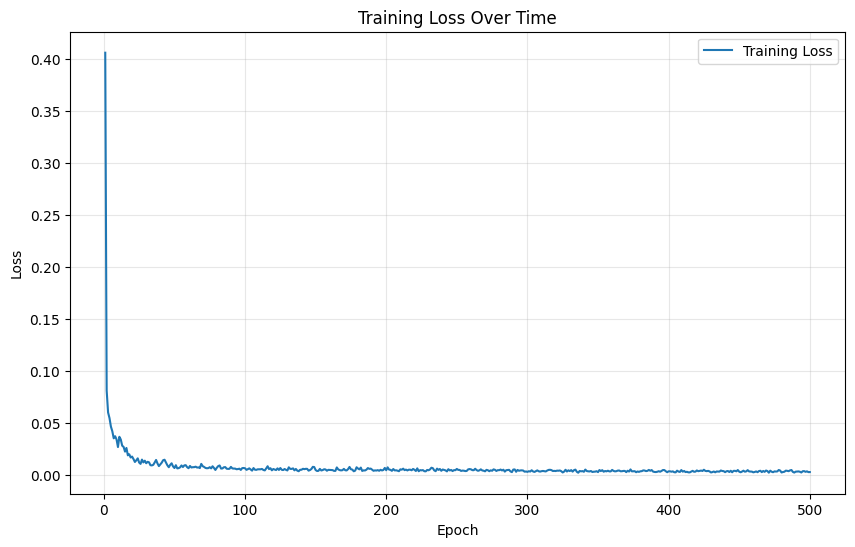

Training history saved to outputs\training_history.json


In [19]:
# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(history['epochs'], history['train_loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig(OUTPUT_DIR / 'training_loss.png', dpi=150, bbox_inches='tight')
plt.show()

# Save history
with open(OUTPUT_DIR / 'training_history.json', 'w') as f:
    json.dump(history, f, indent=2)

print(f"Training history saved to {OUTPUT_DIR / 'training_history.json'}")

## 11. Generate Final Samples

In [21]:
# Generate samples for each class
print("Generating final samples...")

# Generate strabismus samples
strab_samples, strab_labels = sample_images(
    model, scheduler, num_samples=8, 
    classes=[0] * 8,  # All strabismus
    device=device
)

# Generate normal samples
normal_samples, normal_labels = sample_images(
    model, scheduler, num_samples=8,
    classes=[1] * 8,  # All normal
    device=device
)

# Visualize
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

# Plot strabismus samples
for i in range(8):
    row = i // 4
    col = i % 4
    img = (strab_samples[i] + 1) / 2
    img = torch.clamp(img, 0, 1)
    axes[row, col].imshow(img.permute(1, 2, 0).cpu().numpy())
    axes[row, col].set_title('Strabismus')
    axes[row, col].axis('off')

# Plot normal samples
for i in range(8):
    row = (i // 4) + 2
    col = i % 4
    img = (normal_samples[i] + 1) / 2
    img = torch.clamp(img, 0, 1)
    axes[row, col].imshow(img.permute(1, 2, 0).cpu().numpy())
    axes[row, col].set_title('Normal')
    axes[row, col].axis('off')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'final_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print("Final samples generated!")

Generating final samples...


Sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

AttributeError: 'NoneType' object has no attribute '_log'

## 12. Load Checkpoint and Continue Training (Optional)

In [ ]:
# Uncomment and modify to load a checkpoint
'''
checkpoint_path = CHECKPOINT_DIR / "checkpoint_epoch_0100.pt"
checkpoint = torch.load(checkpoint_path)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch'] + 1

print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
print(f"Loss: {checkpoint['loss']:.6f}")
print(f"Resuming training from epoch {start_epoch}")
'''

## 13. Utilities - Sample Specific Classes

In [ ]:
def generate_class_samples(model, scheduler, class_label, num_samples=16, device='cuda'):
    """
    Generate samples for a specific class.
    
    Args:
        class_label: 0 for Strabismus, 1 for Normal
        num_samples: Number of samples to generate
    """
    class_names = {0: 'Strabismus', 1: 'Normal'}
    
    print(f"Generating {num_samples} {class_names[class_label]} samples...")
    
    samples, labels = sample_images(
        model, scheduler,
        num_samples=num_samples,
        classes=[class_label] * num_samples,
        device=device
    )
    
    # Visualize
    samples_denorm = (samples + 1) / 2
    samples_denorm = torch.clamp(samples_denorm, 0, 1)
    
    grid = make_grid(samples_denorm, nrow=4, padding=2)
    plt.figure(figsize=(12, 12))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.title(f"Generated {class_names[class_label]} Samples")
    plt.axis('off')
    plt.show()
    
    return samples, labels

# Example: Generate 16 strabismus samples
# strab_samples, _ = generate_class_samples(model, scheduler, class_label=0, num_samples=16)

# Example: Generate 16 normal samples
# normal_samples, _ = generate_class_samples(model, scheduler, class_label=1, num_samples=16)

## 14. Export Model for Inference

In [ ]:
# Save final model
final_model_path = OUTPUT_DIR / 'final_model.pt'
torch.save({
    'model_state_dict': model.state_dict(),
    'config': {
        'img_size': IMG_SIZE,
        'num_classes': NUM_CLASSES,
        'channels': CHANNELS,
        'timesteps': TIMESTEPS,
        'beta_start': BETA_START,
        'beta_end': BETA_END,
    }
}, final_model_path)

print(f"Final model saved to {final_model_path}")
print(f"\nTo load this model later:")
print(f"checkpoint = torch.load('{final_model_path}')")
print(f"model.load_state_dict(checkpoint['model_state_dict'])")